# Data

## Load Data

In [1]:
import os
import json
from PyPDF2 import PdfReader

In [2]:
data_folder = "../Data"
pdf_files = [f for f in os.listdir(data_folder) if f.endswith('.pdf')]

## Extract Text from PDFs

In [3]:
# Function to extract text from a single PDF file
def extract_text_from_pdf(pdf_path):
    pdf_reader = PdfReader(pdf_path)
    pages_text = {}
    
    for page_num in range(len(pdf_reader.pages)):
        page = pdf_reader.pages[page_num]
        pages_text[str(page_num + 1)] = page.extract_text()  # Store the text with page number as key
    
    return pages_text

In [4]:
# Initialize an empty list to store all books' data
books_data = []

# Iterate over each PDF file in the folder
for pdf_file in pdf_files:
    pdf_path = os.path.join(data_folder, pdf_file)
    
    # Extract text from the PDF file
    book_text = extract_text_from_pdf(pdf_path)
    
    # Remove the ".pdf" extension from the file name
    book_name = os.path.splitext(pdf_file)[0]
    
    # Add book data to the list
    book_data = {
        "book_name": book_name,
        "pages": book_text
    }
    books_data.append(book_data)

In [5]:
# Prepare the final JSON structure
json_data = {
    "books": books_data
}

## Remove Unwntend Text

In [6]:
# Preprocess text in json_data by removing unwanted text from all pages
def preprocess_json_data(json_data, unwanted_text):
    for book in json_data['books']:
        for page_number, page_text in book['pages'].items():
            # Clean the text on each page
            book['pages'][page_number] = page_text.replace(unwanted_text, "")

In [8]:
# Unwanted text to remove
unwanted_text = "دراسات اتريخية| اإلمام محمد بن سعود"
#"دراسات اتريخية| اإلمام محمد بن سعود"
#"دراسات تاريخية| اإلمام محمد بن سعود"

# Preprocess the extracted JSON data
preprocess_json_data(json_data, unwanted_text)

In [9]:
print(json_data['books'][0]['pages']['1'])

98
 
جودة الحياة
 في الدولة السعودية األولى
الدرعية العاصمة نموذجاً
د. بدران بن عبدالرحمن الحنيحن


## Remove Page Numbers

In [10]:
# Function to preprocess and clean extracted text by removing the first line (which contains the page number)
def preprocess_json_data_remove_page_numbers(json_data):
    for book in json_data['books']:
        for page_number, page_text in book['pages'].items():
            # Split the text into lines, skip the first line (assumed to be the page number)
            lines = page_text.split('\n')
            if len(lines) > 1:
                # Remove the first line (page number) and join the rest
                cleaned_text = "\n".join(lines[1:])
                book['pages'][page_number] = cleaned_text
            else:
                # If there's only one line (rare case), keep it as is or set to an empty string
                book['pages'][page_number] = ""

# Preprocess the JSON data to remove page numbers
preprocess_json_data_remove_page_numbers(json_data)

In [11]:
print(json_data['books'][5]['pages']['1'])

 
والدة  اإلمام
 محمد بن سعود 
وإمامته وصفحات لم 
تُكتب في اتريخه
د. عبدهللا بن سعد بن محمد أابحسين


## Remove Specific Pages

In [12]:
def remove_specific_pages(json_data):
    # Remove page 2 from all books
    for book in json_data['books']:
        if '2' in book['pages']:
            del book['pages']['2']
    
    # Remove the last two pages from book 3
    if len(json_data['books']) >= 3:
        book_3_pages = json_data['books'][3]['pages']
        last_page_3 = str(max(map(int, book_3_pages.keys())))
        second_last_page_3 = str(int(last_page_3) - 1)
        if last_page_3 in book_3_pages:
            del book_3_pages[last_page_3]
        if second_last_page_3 in book_3_pages:
            del book_3_pages[second_last_page_3]

    # Remove the last page from books 1, 4, and 5
    for idx in [1, 4, 5]:
        if len(json_data['books']) > idx:
            book_pages = json_data['books'][idx]['pages']
            last_page = str(max(map(int, book_pages.keys())))
            if last_page in book_pages:
                del book_pages[last_page]

    return json_data

# Apply the page removal to the json_data
remove_pages = remove_specific_pages(json_data)

## Merge All Pages

In [13]:
def merge_all_pages(json_data):
    books_data = []
    
    # Iterate over each book
    for book in json_data['books']:
        merged_text = ""
        
        # Merge all pages text into one string
        for page_num, page_text in book['pages'].items():
            merged_text += page_text.strip() + " "  # Add space between pages
        
        # Create the simplified structure
        books_data.append({
            "title": book['book_name'],
            "text": merged_text.strip()  # Remove any extra spaces at the end
        })
    
    return books_data

# Apply the function to merge all pages for each book
merged_books_data = merge_all_pages(remove_pages)

## Save as json

In [14]:
# Specify the output file path
output_file = os.path.join(data_folder, "books_data.json")

# Save the JSON data to a file
with open(output_file, 'w', encoding='utf-8') as f:
    json.dump(merged_books_data, f, ensure_ascii=False, indent=4)

In [15]:
# Save with pages 
output_file = os.path.join(data_folder, "books_data_pages.json")

# Save the JSON data to a file
with open(output_file, 'w', encoding='utf-8') as f:
    json.dump(remove_pages, f, ensure_ascii=False, indent=4)

## Use LLM to make data more powerful

In [1]:
data_folder = "../Data"
with open(f'{data_folder}/books_data.json', 'r') as file:
    ds = json.load(file)

In [3]:
import openai
import getpass

openai.api_key = getpass.getpass(prompt="Enter your OpenAI API key: ")

Enter your OpenAI API key:  ········


In [4]:
# Function to send the prompt to GPT-4o-mini and save as JSON
def send_to_gpt4o_mini_and_save_as_json(prompt, output_file):
    response = openai.ChatCompletion.create(
        model="gpt-4o-mini",  # Using the gpt-4o-mini model
        messages=[
            {"role": "system", "content": "You are a helpful assistant."},  # Optional system role
            {"role": "user", "content": prompt}  # The user's input as the prompt
        ],
        max_tokens=3000,  # Adjust token limit based on the length of the text
        temperature=0.7,  # Adjust temperature based on deterministic or creative needs
        n=1,
        stop=None
    )
    
    # Get the raw response from GPT
    json_response = response['choices'][0]['message']['content'].strip()

    # Debug: Print raw response for inspection
    print(f"Raw GPT Response:\n{json_response}\n")
    
    # Save the response directly as JSON
    try:
        json_data = json.loads(json_response)  # Attempt to parse the response as JSON
        with open(output_file, 'w', encoding='utf-8') as json_file:
            json.dump(json_data, json_file, ensure_ascii=False, indent=4)
        print(f"Response successfully saved to {output_file}")

    except json.JSONDecodeError as e:
        print(f"Failed to decode JSON: {e}")
        print(f"Raw response:\n{json_response}")

In [ ]:
# Function to create the one-prompt instruction for the model
def create_one_prompt_instruction(book_id, title, text):
    prompt = f"""
    Please process the following text and return the result in **pure JSON format** with sections, paragraphs, and each paragraph's structured keywords and category in Arabic.

    **IMPORTANT**: 
    - **DO NOT SKIP ANY WORDS**. 
    - **Only correct spelling mistakes** without changing the meaning or rephrasing sentences.
    - **Ensure each name is correctly paired with its relationship** (e.g., "موضي بنت سلطان" → "زوجة").

    ### Instructions:
    1. **Extract Structured Keywords**:
       - Use the following structure for keywords:
         ```json
         [
           {{"name": "محمد بن سعود", "relationship": "إمام"}},
           {{"name": "سعود الأول بن محمد", "relationship": "والد"}},
           {{"name": "موضي بنت سلطان", "relationship": "زوجة"}}
         ]
         ```
       - Ensure **every name and relationship is correctly captured and paired**.

    2. **Assign a Category in Arabic**:
       - Assign a specific category (e.g., "تاريخ", "علوم", "فلسفة", "تكنولوجيا") to each paragraph based on its topic.

    3. **Merge Similar Paragraphs**:
       - Combine paragraphs discussing the **same topic**, ensuring all content is included without skipping any words.

    4. **Identify Section Titles**:
       - Any line with a colon (`:`) is treated as a **section title**. Use the text before the colon as the title.

    5. **Correct Spelling Mistakes Only**:
       - Correct **only spelling errors** without rephrasing sentences or altering their meaning.

    ### Output JSON Structure:
    ```json
    {{
      "book_id": "{book_id}",
      "title": "{title}",
      "sections": [
        {{
          "section_id": "1",
          "section_title": "العنوان الرئيسي",
          "paragraphs": [
            {{
              "paragraph_id": "1",
              "text": "النص المصحح مع الحفاظ على جميع الكلمات.",
              "keywords": [
                {{"name": "محمد بن سعود", "relationship": "إمام"}},
                {{"name": "سعود الأول بن محمد", "relationship": "والد"}},
                {{"name": "موضي بنت سلطان", "relationship": "زوجة"}}
              ],
              "category": "تاريخ"
            }}
          ]
        }}
      ]
    }}
    ```

    ### Here is the text to process:

    {text}
    """
    
    return prompt


In [10]:
# Function to save the response in a JSON file
def save_response_to_json(response_data, output_file):
    with open(output_file, 'w', encoding='utf-8') as json_file:
        json.dump(response_data, json_file, ensure_ascii=False, indent=4)
    print(f"Response saved to {output_file}")

In [11]:
# Function to process the dataset and save responses as JSON
def process_dataset_and_save(dataset, output_file):
    for idx, entry in enumerate(dataset):
        title = entry["title"]
        text = entry["text"]
        book_id = str(idx + 1)  # Generate a unique book_id for each entry
        
        # Create the one-prompt instruction for the current entry
        prompt = create_one_prompt_instruction(book_id, title, text)
        
        # Send the prompt to GPT-4o-mini and save the response directly as JSON
        send_to_gpt4o_mini_and_save_as_json(prompt, output_file)

In [ ]:
# Process the dataset and save the result in a JSON file
output_file = "finl_responses.json"
process_dataset_and_save(ds, output_file)

In [13]:
with open(f'{data_folder}/books_data_finl.json', 'r') as file:
    ds = json.load(file)

## Convert Json to Dataframe

In [14]:
import json
import pandas as pd

df = pd.json_normalize(
    ds,
    record_path=['sections', 'paragraphs'],
    meta=['book_id', 'title', ['sections', 'section_id'], ['sections', 'section_title']]
)

In [15]:
df[df['book_id'] == "4"].head()

paragraph_id                                               text  \
22        4.1.1  على الرغم من اتفاق المؤرخين أن الإمام محمد بن ...   
23        4.1.2  واعتمدت الدراسة على مصادر متنوعة يأتي في مقدمت...   
24        4.1.3  أما المصدر الثالث فهو كتاب: (لمع الشهاب في سير...   
25        4.1.4  هذا إضافة إلى بعض المعلومات التي كتبها ضابط ال...   
26        4.1.5  وتتناول الدراسة مقدمة ومباحث عدة تتناول الحديث...   

                                             keywords category book_id  \
22  [الإمام محمد بن سعود, تأسيس الدولة, الدولة الس...    تاريخ       4   
23  [مصادر الدراسة, ابن غنام, عثمان بن بشر, تاريخ ...    تاريخ       4   
24  [كتاب لمع الشهاب, محمد بن عبدالوهاب, المتحف ال...    تاريخ       4   
25  [جان ريمون, التذكرة في أصل الوهابيين, جون لويس...    تاريخ       4   
26  [الإمام محمد بن سعود, صفات الإمام, أعماله, وفا...    تاريخ       4   

                                 title sections.section_id  \
22  جوانب من شخصية الإمام محمد بن سعود                 4.1   
23  جوانب من شخصية الإمام محمد بن سعود                 4.1   
24  جوانب من شخصية الإمام محمد بن سعود                 4.1   
25  جوانب من شخصية الإمام محمد بن سعود                 4.1   
26  جوانب من شخصية الإمام محمد بن سعود                 4.1   

                               sections.section_title  
22  جوانب من شخصية الإمام محمد بن سعود وأتسيسه للدولة  
23  جوانب من شخصية الإمام محمد بن سعود وأتسيسه للدولة  
24  جوانب من شخصية الإمام محمد بن سعود وأتسيسه للدولة  
25  جوانب من شخصية الإمام محمد بن سعود وأتسيسه للدولة  
26  جوانب من شخصية الإمام محمد بن سعود وأتسيسه للدولة

In [16]:
df.to_pickle(f'{data_folder}/data.pickel')

## Preprocessing data

In [17]:
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import arabic_reshaper
from bidi.algorithm import get_display
from wordcloud import WordCloud
from PIL import Image
import numpy as np
from camel_tools.utils.dediac import dediac_ar
from camel_tools.utils.normalize import normalize_alef_ar, normalize_teh_marbuta_ar, normalize_unicode
import re
from camel_tools.tokenizers.word import simple_word_tokenize


df = pd.read_pickle('../Data/data.pickel')

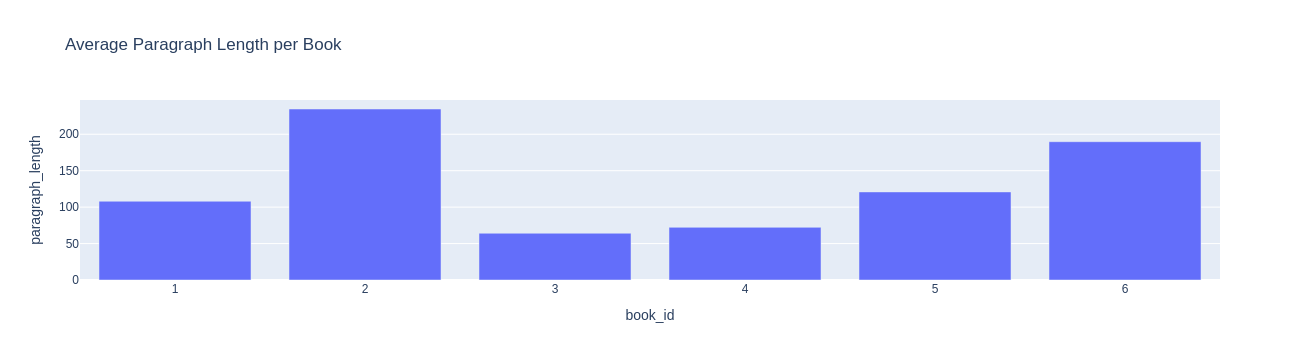

In [3]:
df['paragraph_length'] = df['text'].apply(lambda x: len(x.split()))
avg_paragraph_length = df.groupby('book_id')['paragraph_length'].mean().reset_index()
fig = px.bar(avg_paragraph_length, x='book_id', y='paragraph_length', title='Average Paragraph Length per Book')
fig.show()

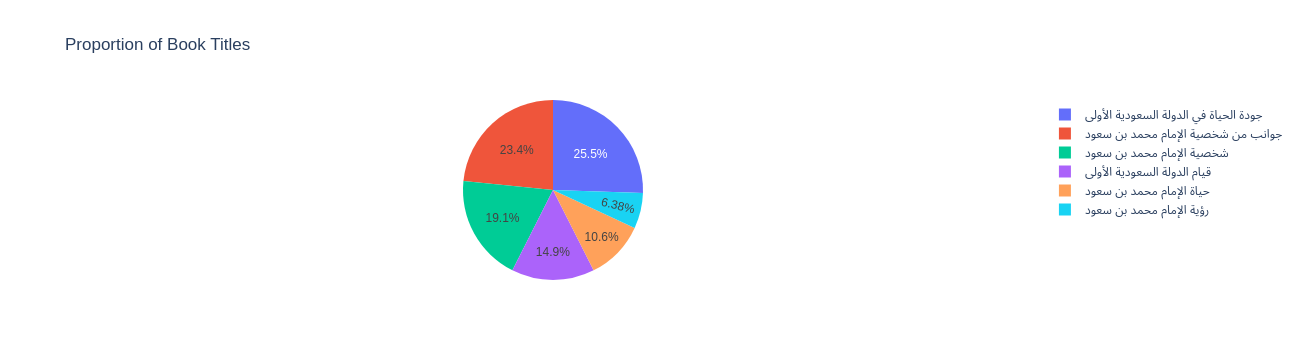

In [4]:
fig = px.pie(df, names='title', title='Proportion of Book Titles')
fig.show()

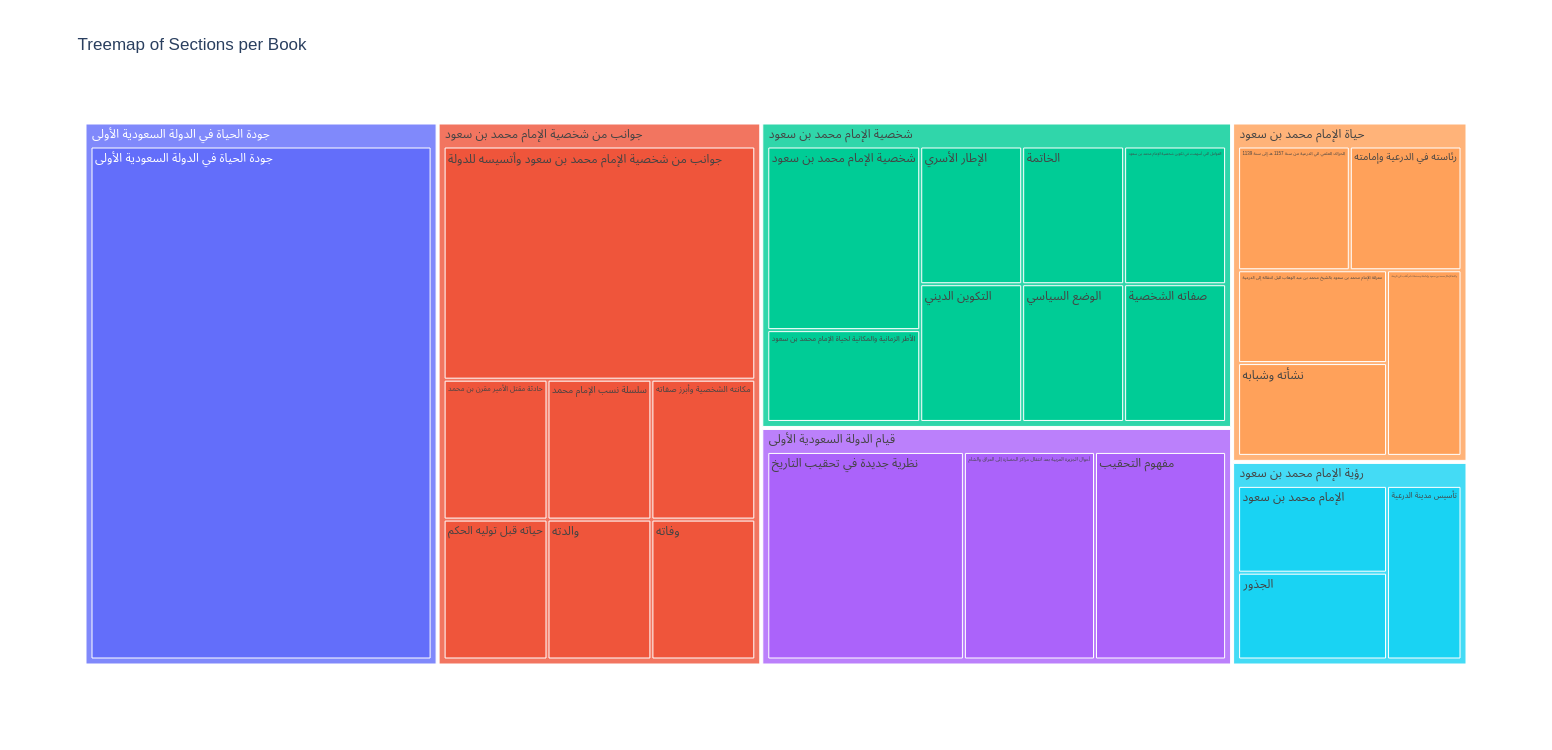

In [5]:
fig = px.treemap(df, path=['title', 'sections.section_title'], title='Treemap of Sections per Book')
fig.update_layout(width=1500, height=750) 
fig.show()

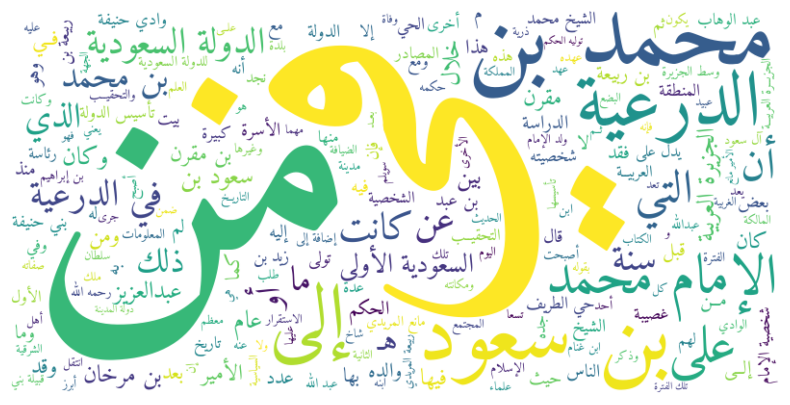

In [6]:
all_words = []
for paragraph in df['text']:
    words = paragraph.split()  
    all_words.extend(words)
text = ' '.join(all_words)
reshaped_text = arabic_reshaper.reshape(text)
display_text = get_display(reshaped_text)
wordcloud = WordCloud(font_path='../fonts/Amiri-Regular.ttf', width=800, height=400, background_color='white').generate(display_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  
plt.show()

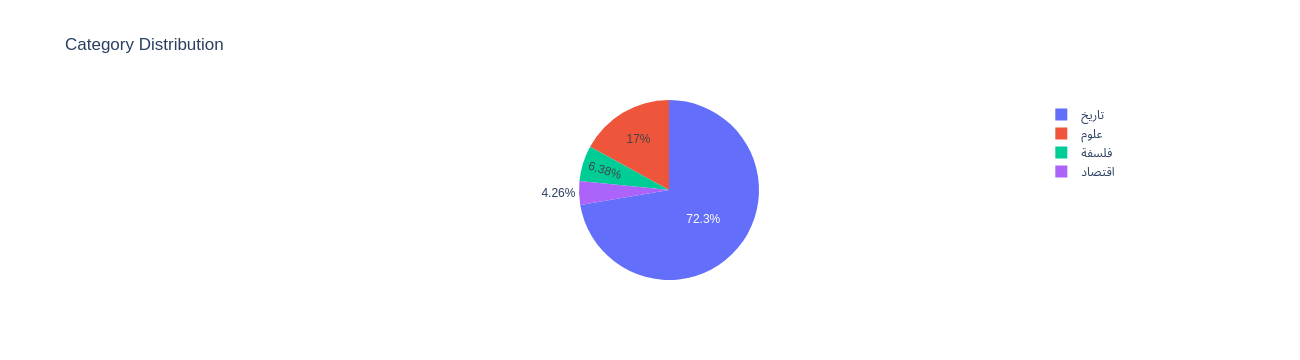

In [7]:
category_counts = df['category'].value_counts().reset_index()
category_counts.columns = ['category', 'count']
fig = px.pie(category_counts, values='count', names='category', title='Category Distribution')
fig.show()

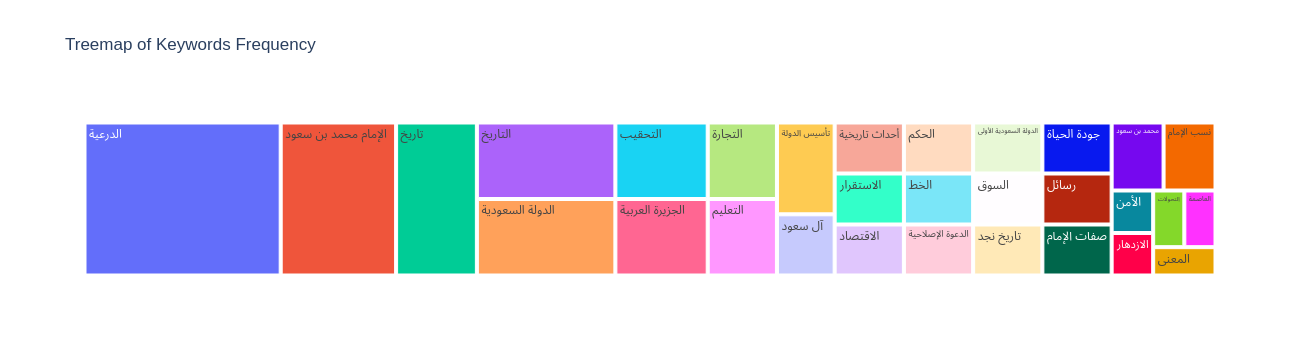

In [8]:
all_keywords = []
for keywords in df['keywords']:
    all_keywords.extend(keywords)  # Extend the list with the keywords
keyword_counts = Counter(all_keywords).most_common(30)  # Top 30 keywords
keyword_df = pd.DataFrame(keyword_counts, columns=['keyword', 'count'])
fig = px.treemap(keyword_df, path=['keyword'], values='count', title='Treemap of Keywords Frequency')
fig.show()

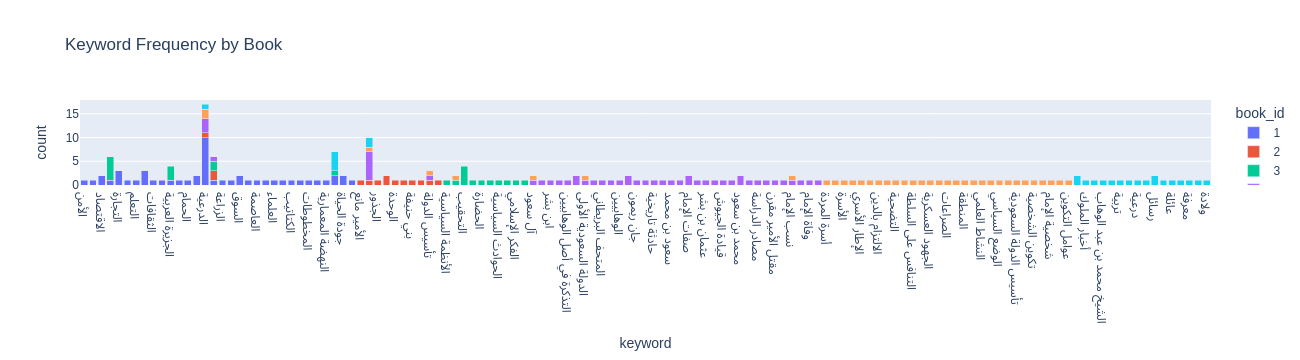

In [9]:
keyword_book_data = []

for _, row in df.iterrows():
    for keyword in row['keywords']:
        keyword_book_data.append({'book_id': row['book_id'], 'keyword': keyword})
keyword_book_df = pd.DataFrame(keyword_book_data)
keyword_counts = keyword_book_df.groupby(['book_id', 'keyword']).size().reset_index(name='count')
fig = px.bar(keyword_counts, x='keyword', y='count', color='book_id', title='Keyword Frequency by Book', barmode='stack')
fig.show()

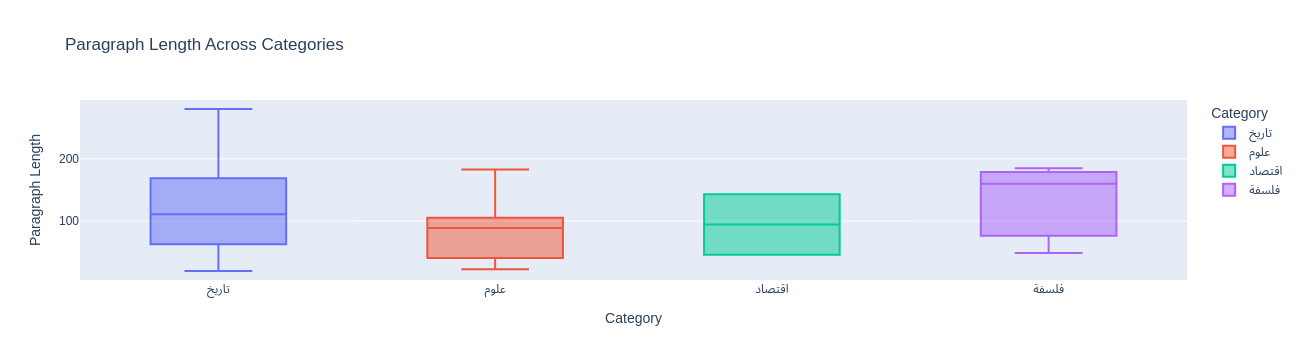

In [10]:
fig = px.box(df, x='category', y='paragraph_length', 
             color='category',  # Optional: color the boxes by category
             title='Paragraph Length Across Categories',
             labels={'category':'Category', 'paragraph_length':'Paragraph Length'})
fig.show()

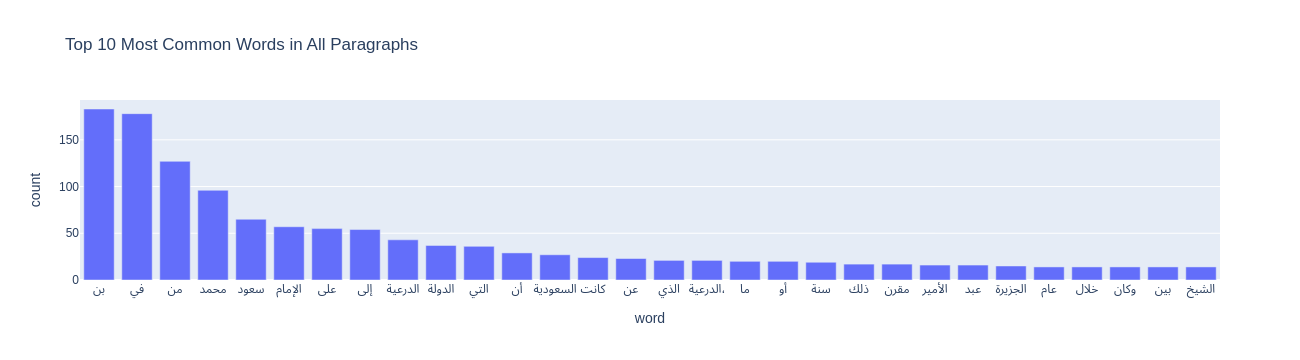

In [11]:
word_counts = Counter(all_words)
most_common_words = word_counts.most_common(30)  
common_words_df = pd.DataFrame(most_common_words, columns=['word', 'count'])
fig = px.bar(common_words_df, x='word', y='count', title='Top 10 Most Common Words in All Paragraphs')
fig.show()

In [5]:
with open('../Data/list_stopwords.txt', 'r', encoding='utf-8') as f:
    custom_stopwords = f.read().splitlines()

In [6]:
def remove_custom_stopwords(text, stopwords):
    words = simple_word_tokenize(text)    
    filtered_words = [word for word in words if word not in stopwords]    
    return ' '.join(filtered_words)

In [14]:
df['text_stopwords'] = df['text'].apply(lambda x: remove_custom_stopwords(x, custom_stopwords))

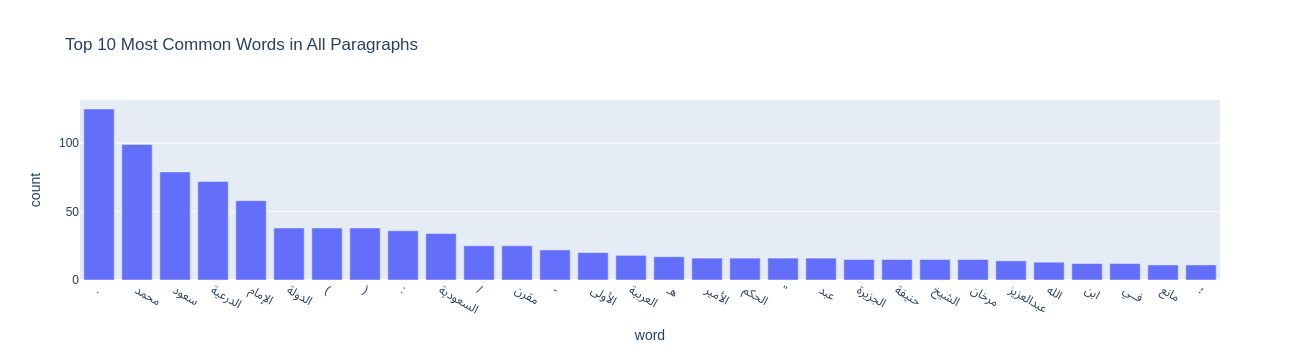

In [15]:
all_words = []
for paragraph in df['text_stopwords']:
    words = paragraph.split()  
    all_words.extend(words)
word_counts = Counter(all_words)
most_common_words = word_counts.most_common(30)  
common_words_df = pd.DataFrame(most_common_words, columns=['word', 'count'])
fig = px.bar(common_words_df, x='word', y='count', title='Top 10 Most Common Words in All Paragraphs')
fig.show()

In [3]:
def normalize_arabic_text(text):
    # Step 1: Remove diacritics
    text = dediac_ar(text)
    
    # Step 2: Normalize Unicode characters
    text = normalize_unicode(text)
    
    # Step 3: Normalize different forms of Alef (أ, إ, آ to ا)
    text = normalize_alef_ar(text)
    
    # Step 4: Normalize Teh Marbuta (ة to ه)
    text = normalize_teh_marbuta_ar(text)
    
    # Step 5: Remove Tatweel
    text = re.sub(r'ـ+', '', text)
    
    # Step 6: Convert ئ, ؤ to ء
    text = re.sub(r'[ئؤ]', 'ء', text)

    # Step 7: Remove any punctuation (non-word characters)
    text = re.sub(r'[^\w\s]', '', text)

    return text

In [17]:
df['cleaned_text'] = df['text_stopwords'].apply(normalize_arabic_text)

In [18]:
custom_stopwords.append('ابن')

In [19]:
df['cleaned_text'] = df['cleaned_text'].apply(lambda x: remove_custom_stopwords(x, custom_stopwords))

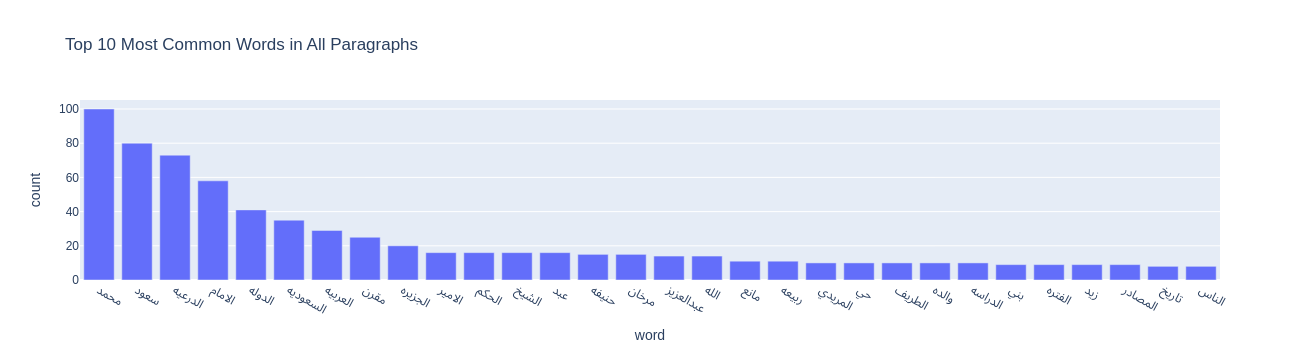

In [20]:
all_words = []
for paragraph in df['cleaned_text']:
    words = paragraph.split()  
    all_words.extend(words)
word_counts = Counter(all_words)
most_common_words = word_counts.most_common(30)  
common_words_df = pd.DataFrame(most_common_words, columns=['word', 'count'])
fig = px.bar(common_words_df, x='word', y='count', title='Top 10 Most Common Words in All Paragraphs')
fig.show()

In [4]:
def normalize_name_spacing(text):
    text = re.sub(r'عبد\sالله', 'عبدالله', text)    
    text = re.sub(r'عبد\sالعزيز', 'عبدالعزيز', text)    
    text = re.sub(r'عبد\sالرحمن', 'عبدالرحمن', text)    
    text = re.sub(r'عبد\sالوهاب', 'عبدالوهاب', text)
    
    return text

In [22]:
df['cleaned_text'] = df['cleaned_text'].apply(normalize_name_spacing)

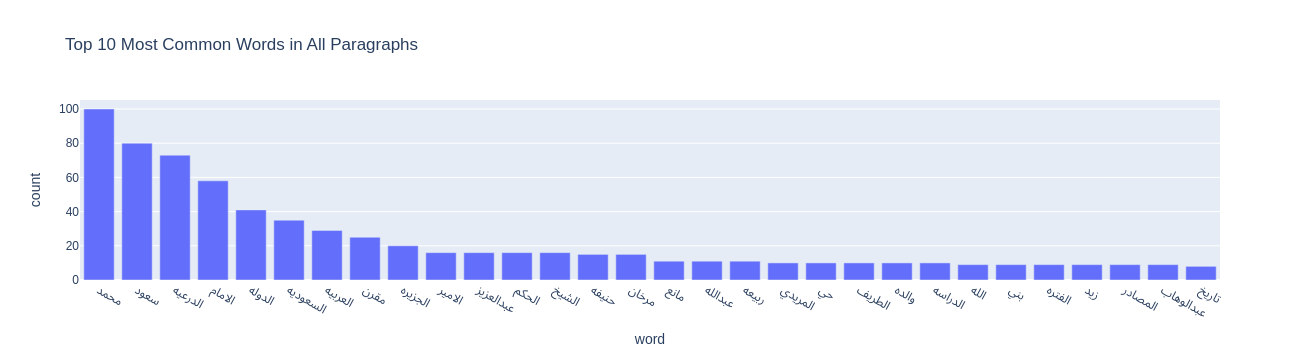

In [23]:
all_words = []
for paragraph in df['cleaned_text']:
    words = paragraph.split()  
    all_words.extend(words)
word_counts = Counter(all_words)
most_common_words = word_counts.most_common(30)  
common_words_df = pd.DataFrame(most_common_words, columns=['word', 'count'])
fig = px.bar(common_words_df, x='word', y='count', title='Top 10 Most Common Words in All Paragraphs')
fig.show()

In [26]:
df.head()

paragraph_id                                               text  \
0        1.1.1  في ثنايا صفحات تاريخ المملكة العربية السعودية ...   
1        1.1.2  ويتردد سؤال في ذهن المتأمل في تاريخ الدولة الس...   
2        1.1.3  لمّا أصبحت الدرعية عاصمة للدولة السعودية الأول...   
3        1.1.4  كان مجتمع الدولة السعودية الأولى في الدرعية مج...   
4        1.1.5  جرت العادة في منطقة نجد أن يستضيف المرءُ ضيوفه...   

                                            keywords category book_id  \
0  [تاريخ, الدولة السعودية, التحولات, الازدهار, ج...    تاريخ       1   
1              [تاريخ, الدرعية, جودة الحياة, المعنى]    تاريخ       1   
2  [الدرعية, العاصمة, النهضة المعمارية, القصور, ا...    تاريخ       1   
3                  [مجتمع, الزراعة, السكان, الدرعية]    تاريخ       1   
4               [الضيافة, الحمام, الدرعية, الاقتصاد]    تاريخ       1   

                                   title sections.section_id  \
0  جودة الحياة في الدولة السعودية الأولى                 1.1   
1  جودة الحياة في الدولة السعودية الأولى                 1.1   
2  جودة الحياة في الدولة السعودية الأولى                 1.1   
3  جودة الحياة في الدولة السعودية الأولى                 1.1   
4  جودة الحياة في الدولة السعودية الأولى                 1.1   

                  sections.section_title  paragraph_length  \
0  جودة الحياة في الدولة السعودية الأولى               189   
1  جودة الحياة في الدولة السعودية الأولى                62   
2  جودة الحياة في الدولة السعودية الأولى               159   
3  جودة الحياة في الدولة السعودية الأولى                98   
4  جودة الحياة في الدولة السعودية الأولى               192   

                                      text_stopwords  \
0  ثنايا صفحات تاريخ المملكة العربية السعودية الح...   
1  ويتردد سؤال ذهن المتأمل تاريخ الدولة السعودية ...   
2  أصبحت الدرعية عاصمة للدولة السعودية الأولى ازد...   
3  مجتمع الدولة السعودية الأولى الدرعية مجتمعًا م...   
4  جرت العادة منطقة نجد يستضيف المرءُ ضيوفه منزله...   

                                        cleaned_text  
0  ثنايا صفحات تاريخ المملكه العربيه السعوديه الح...  
1  ويتردد سءال ذهن المتامل تاريخ الدوله السعوديه ...  
2  اصبحت الدرعيه عاصمه للدوله السعوديه ازدادت اعد...  
3  مجتمع الدوله السعوديه الدرعيه مجتمعا مدنيا يخت...  
4  جرت العاده منطقه نجد يستضيف المرء ضيوفه منزله ...

## Embedding

In [24]:
df.to_pickle('../Data/cleand_data.pickle')

In [25]:
df = pd.read_pickle('../Data/cleand_data.pickle')

In [30]:
import openai
import getpass

openai.api_key = getpass.getpass(prompt="Enter your OpenAI API key: ")

Enter your OpenAI API key:  ········


In [33]:
def embed_text(text):
    response = openai.Embedding.create(
        input=text,
        model="text-embedding-ada-002"
    )
    return response['data'][0]['embedding'] 

In [34]:
df['embeddings'] = df['cleaned_text'].apply(lambda x: embed_text(x))
df.to_pickle('embedded_df.pkl')

In [36]:
df.head(2)

paragraph_id                                               text  \
0        1.1.1  في ثنايا صفحات تاريخ المملكة العربية السعودية ...   
1        1.1.2  ويتردد سؤال في ذهن المتأمل في تاريخ الدولة الس...   

                                            keywords category book_id  \
0  [تاريخ, الدولة السعودية, التحولات, الازدهار, ج...    تاريخ       1   
1              [تاريخ, الدرعية, جودة الحياة, المعنى]    تاريخ       1   

                                   title sections.section_id  \
0  جودة الحياة في الدولة السعودية الأولى                 1.1   
1  جودة الحياة في الدولة السعودية الأولى                 1.1   

                  sections.section_title  paragraph_length  \
0  جودة الحياة في الدولة السعودية الأولى               189   
1  جودة الحياة في الدولة السعودية الأولى                62   

                                      text_stopwords  \
0  ثنايا صفحات تاريخ المملكة العربية السعودية الح...   
1  ويتردد سؤال ذهن المتأمل تاريخ الدولة السعودية ...   

                                        cleaned_text  \
0  ثنايا صفحات تاريخ المملكه العربيه السعوديه الح...   
1  ويتردد سءال ذهن المتامل تاريخ الدوله السعوديه ...   

                                          embeddings  
0  [-0.001666962169110775, -0.014609554782509804,...  
1  [-0.0031422919128090143, -0.01093146950006485,...

In [42]:
df.columns

Index(['paragraph_id', 'text', 'keywords', 'category', 'book_id', 'title',
       'sections.section_id', 'sections.section_title', 'paragraph_length',
       'text_stopwords', 'cleaned_text', 'embeddings'],
      dtype='object')

## Qdrant

In [7]:
from qdrant_client import QdrantClient
from qdrant_client.http import models

cloud_client = QdrantClient(
    url="https://dbf8b0b1-79e9-47b1-9e54-4f8dd8c1793f.europe-west3-0.gcp.cloud.qdrant.io", 
    api_key="-TUh0B2KvsHGUaSs2V4ss5lNoAoVAt3-K-gpsqe81UAP8UHZalBgmw"
)

In [41]:
cloud_client.recreate_collection(
    collection_name="collection", 
    vectors_config=models.VectorParams(size=1536, distance=models.Distance.COSINE),
)

/tmp/ipykernel_8961/563637334.py:1: DeprecationWarning:

`recreate_collection` method is deprecated and will be removed in the future. Use `collection_exists` to check collection existence and `create_collection` instead.



True

In [43]:
points = [
    {
        "id": idx,  # The unique id for each point
        "vector": row['embeddings'],  # The embeddings stored in the 'embeddings' column
        "payload": {
            "title": row['title'],  # Access the 'title' field from the DataFrame
            "section": row['sections.section_title'],  # Access the 'sections.section_title' field
            "text": row["text"]  # Access the 'text' field
        }
    }
    for idx, row in df.iterrows()  
]

cloud_client.upsert(
    collection_name="collection",  
    points=points  
)

print("Points upserted successfully!")

Points upserted successfully!


In [9]:
def embed_text(text):
    response = openai.Embedding.create(
        input=text,
        model="text-embedding-ada-002"
    )
    return response['data'][0]['embedding'] 

In [10]:
query = 'من هم ابناء الامام'
query = remove_custom_stopwords(query , custom_stopwords)
query = normalize_arabic_text(query)
query_embedding = embed_text(query)

In [11]:
search_results = cloud_client.search(
    collection_name="collection",  
    query_vector=query_embedding, 
    limit=3 
)

for result in search_results:
    print(f"ID: {result.id}, Score: {result.score}")
    print(f"Title: {result.payload['title']}")
    print(f"Section: {result.payload['section']}")
    print(f"Text: {result.payload['text']}\n")

ID: 28, Score: 0.85662276
Title: جوانب من شخصية الإمام محمد بن سعود
Section: والدته
Text: ورُزق بابنه الأمير عبدالعزيز سنة 1679/هـ 1090 ولد الإمام محمد بن سعود عام 1750/هـ 1163 وهو في سن الثانية والأربعين من عمره، وترك له قيادة جيوش الدولة سنة تجاوز السبعين عامًا.

ID: 8, Score: 0.8487077
Title: جودة الحياة في الدولة السعودية الأولى
Section: جودة الحياة في الدولة السعودية الأولى
Text: فقد كان الفتيان من أهل الدرعية إذا انتهوا من المعلم يذهبون إلى الأئمة بألواحهم، ويعرضون عليهم خطوطهم، فمن استُحسن خطه منهم أعطوه جزيلاً.

ID: 43, Score: 0.8455684
Title: حياة الإمام محمد بن سعود
Section: نشأته وشبابه
Text: نشأ الإمام محمد بن سعود في بيت ملك ورئاسة، فإن والده وجده كانا رئيسين في غصيبة، ومن السائد في بيوت الملوك والرؤساء سلوك أنماط تربية تُعدّ الناشئة لحفظ المكتسبات، وتُدرك مداخل الشرور، ومكامن الأخطار، فتُعمر مجالسهم بأشباه الحوادث ومثلات الأيام، وتغدو نماذج يتأسى بها اللبيب، وتروح أخرى تزجر الفطِن، وتُشحذ بين هذه وتلك آلية القياس في العقول، ويقوى الاعتبار، وتعظم العظة، ويتيقن البصير أن ال

## RAG ALLaM

In [93]:
import json
from ibm_watsonx_ai.foundation_models import Model

# Function to get credentials for the model
def get_credentials():
    return {
        "url": "https://eu-de.ml.cloud.ibm.com",
        "apikey": "Og2w9SCjHAskHXJSyimYG1vfLtA9cucZCST5KSsQFq-h"
    }

# Function to load the IBM Watson model
def get_model():
    project_id = "3a8440c4-195f-4d43-8f7d-508334622851"
    model_id = "sdaia/allam-1-13b-instruct"
    parameters = {
        "decoding_method": "greedy",
        "max_new_tokens": 900,
        "repetition_penalty": 1
    }
    return Model(
        model_id=model_id,
        params=parameters,
        credentials=get_credentials(),
        project_id=project_id
    )

In [94]:
model = get_model()

In [95]:
def answer(query, search_results, model):
    results_context = " ".join([result.payload['text'] for result in search_results])  # Fixed: removed need to re-process    
    generated_prompt = multiprompt(query, [result.payload['text'] for result in search_results])  # Passing list of texts
    model_answer = model.generate_text(prompt=generated_prompt, guardrails=False)

    return model_answer

In [96]:
def multiprompt(query, results):
    results_context = " ".join(results)
    
    formatted_query = f"<s> [INST] {query} [/INST]"

    character_prompt = (
        f"The answer must be a cohesive and historically accurate narrative without using bullet points or enumerations. "
        f"The language should be formal and easy to comprehend while maintaining a scholarly tone. "
        f"The response should reflect an expert-level understanding of the historical period being discussed. "
        f"Refrain from including unnecessary introductions or conclusions. "
        f"Focus solely on delivering a detailed and factual account in Arabic. "
        f"The query is: '{query}'. "
        f"You may use the provided historical information as context to ensure factual accuracy: {results_context}. "
        f"Maintain the entire response in Arabic with no inclusion of other languages. "
        f"The answer should reflect professionalism and be formatted in Markdown."
    )



    final_prompt = f"{character_prompt} {formatted_query}"
    
    return final_prompt

In [97]:
model_answer = answer(query, search_results, model=model)

In [98]:
print(model_answer)

 الإمام محمد بن سعود بن محمد بن مقرن ولد في عام 1679/1090هـ، وذلك في بيت عائلته المرموقة. كان والده، سعود بن محمد بن مقرن، رئيس منطقة غصيبة. تنتمي عائلة الإمام محمد إلى عشيرة الدروع وقبيلة بني حنيفة العدنانية.

في البداية، ذُكر أن الإمام محمد وُلد في عام 1689/1100هـ، لكن بعض المؤرخين مثل الدكتور منير العجاني والأستاذ عبدالله بن خميس أشاروا إلى أن ولادته كانت في عام 1679/1090هـ. بخصوص والدته، لم تُؤرخ المصادر تاريخها بدقة. يعتقد الدكتور عبدالرحمن العريني أن رأي العجاني وبن خميس أقرب إلى الصحة.

استنادًا إلى المعلومات المتوفرة، يمكن القول إن الإمام محمد بن سعود عاش لنحو 98 سنة. ووفقًا للشيخ حسين بن غنام في كتابه "العقد الثمين"، توفي الإمام محمد بعد أن تجاوز سن الثمانين ببضع سنوات.

في حياته المبكرة، نشأ الإمام محمد بن سعود في الدرعية، المدينة التي شهدت تطورات سياسية وعمرانية هامة. كانت الدرعية مقسمة إلى أحياء تعكس التنافس الداخلي على السلطة بين فروع أسرة المردة. بدأ الإمام محمد حكمه من حي غصيبة، الذي كان يعتبر معقلاً لآل مقرن ومركز الحكم في بداية عهده. مع تطور الدرعية وازدهارها العمراني،